# Transformer for reversing sequences

Transformer with absolute positional encoding to reverse sequences of length 32 consisting of integers from 0 to 9.

- Imports, including `torch` and `pytorch_lightning`.
- `MultiHeadAttention` class using `einsum` and `einops`.
- `EncoderBlock` class.
- `PositionalEncoding` class.
- `TransformerEncoder` class with initial embedding, encoder blocks, and output layer.
- `TransformerPredictor` Lightning module.
- Create datasets and dataloaders.
- Function to train and evaluate model.
- Train and evaluate model (we can get 100% accuracy pretty easily here).
- Display attention maps for each layer (encoder block) and head.
- Print out model structure and the number of trainable parameters.

I didn't use a learning rate scheduler for this exercise.

### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from einops import rearrange

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

pl.seed_everything(42)

CHECKPOINT_PATH = 'checkpoints'

Seed set to 42


### Multi-head attention

In [2]:
class MultiHeadAttention(nn.Module):

    def __init__(self, n_head, d_model, d_k, d_v):
        super().__init__()
        self.n_head = n_head
        self.d_k = d_k

        self.wq = nn.Linear(d_model, n_head * d_k)
        self.wk = nn.Linear(d_model, n_head * d_k)
        self.wv = nn.Linear(d_model, n_head * d_v)

        self.linear = nn.Linear(n_head * d_v, d_model)  

    def forward(self, q, k, v, mask=None):
        q = rearrange(self.wq(q), 'b t (h k) -> b h t k', h=self.n_head)    
        k = rearrange(self.wk(k), 'b s (h k) -> b h s k', h=self.n_head)
        v = rearrange(self.wv(v), 'b s (h v) -> b h s v', h=self.n_head)
        attn = torch.einsum('bhtk, bhsk -> bhts', q, k) / np.sqrt(self.d_k)
        if mask is not None:
            attn = attn.masked_fill(mask==0, -np.inf)
        attn = F.softmax(attn, dim=3)
        out = torch.einsum('bhts, bhsv -> bhtv', attn, v)
        out = rearrange(out, 'b h t v -> b t (h v)')
        out = self.linear(out)
        return out, attn

### Encoder block

In [3]:
class EncoderBlock(nn.Module):

    def __init__(self, n_head, d_model, d_k, d_v, d_ff, dropout_prob=0.0):
        super().__init__()
        self.attn = MultiHeadAttention(n_head, d_model, d_k, d_v)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout_prob)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )

    def forward(self, x, mask=None):
        attn_out, attn_map = self.attn(x, x, x, mask)
        x = self.ln1(x + self.dropout(attn_out))

        mlp_out = self.mlp(x)
        x = self.ln2(x + self.dropout(mlp_out))

        return x


### Positional encoding

In [4]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = rearrange(torch.arange(0, max_len, dtype=torch.float), 'i -> i 1')
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = rearrange(pe, 'max_len d_model -> 1 max_len d_model')
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

### Transformer encoder

In [5]:
class TransformerEncoder(nn.Module):

    def __init__(self, vocab_size, d_model, n_head, 
                    d_k, d_v, d_ff, n_blocks, dropout_prob=0.):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pe = PositionalEncoding(d_model)
        self.enc_blocks = nn.ModuleList(
            [EncoderBlock(n_head, d_model, d_k, d_v, d_ff, dropout_prob=0.0) \
                for _ in range(n_blocks)]
            )
        self.output_layer = nn.Linear(d_model, vocab_size)
    
    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = self.pe(x)
        for block in self.enc_blocks:
            x = block(x, mask)
        x = self.output_layer(x)
        return x

    def get_attn_maps(self, x, mask=None):
        x = self.embedding(x)
        x = self.pe(x)
        attn_maps = []
        for block in self.enc_blocks:
            _, attn_map = block.attn(x, x, x, mask)
            attn_maps.append(attn_map)
            x = block(x, mask)
        return attn_maps

### Lightning module

In [6]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, vocab_size, d_model, d_k, d_v, 
                n_head, n_blocks, dropout_prob=0.1, lr=5e-4):
        super().__init__()
        self.save_hyperparameters()
        self.transformer = TransformerEncoder(
            vocab_size=vocab_size, d_model=d_model, d_k=d_k, d_v=d_v,
            n_head=n_head, n_blocks=n_blocks, d_ff=4*d_model,
            dropout_prob=dropout_prob
        )

    def forward(self, x, mask=None):
        return self.transformer(x, mask)
    
    @torch.no_grad()
    def get_attn_maps(self, x, mask=None):
        return self.transformer.get_attn_maps(x, mask)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), 
                        lr=self.hparams.lr)

    def training_step(self, batch, batch_idx):
        seqs, reversed_seqs = batch
        preds = self.forward(seqs)
        preds = rearrange(preds, 'b t c -> (b t) c')
        reversed_seqs = rearrange(reversed_seqs, 'b t -> (b t)')
        loss = F.cross_entropy(preds, reversed_seqs)
        acc = (preds.argmax(dim=1) == reversed_seqs).float().mean()
        self.log('train_loss', loss)    
        self.log('train_acc', acc)
        return loss
    
    def validation_step(self, batch, batch_idx):
        seqs, reversed_seqs = batch
        preds = self.forward(seqs)
        preds = rearrange(preds, 'b t c -> (b t) c')
        reversed_seqs = rearrange(reversed_seqs, 'b t -> (b t)')
        acc = (preds.argmax(dim=1) == reversed_seqs).float().mean()  
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        seqs, reversed_seqs = batch
        preds = self.forward(seqs)
        preds = rearrange(preds, 'b t c -> (b t) c')
        reversed_seqs = rearrange(reversed_seqs, 'b t -> (b t)')
        acc = (preds.argmax(dim=1) == reversed_seqs).float().mean()  
        self.log('test_acc', acc)    

### Dataset and dataloaders

In [7]:
class ReverseDataset(Dataset):

    def __init__(self, n_samples, seq_len, vocab_size):
        self.data = torch.randint(0, vocab_size, (n_samples, seq_len))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.data[idx].flip(0)

In [8]:
train_loader = DataLoader(ReverseDataset(
    n_samples=10000, seq_len=32, vocab_size=10),
    batch_size=128, shuffle=True)
val_loader = DataLoader(ReverseDataset(
    n_samples=1000, seq_len=32, vocab_size=10),
    batch_size=128)
test_loader = DataLoader(ReverseDataset(
    n_samples=1000, seq_len=32, vocab_size=10),
    batch_size=128)

### Function to train and evaluate transformer

In [9]:
def train_reverse(max_epochs=10):
    
    trainer = Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, 'ReverseTransformer'),
        accelerator='cpu',
        max_epochs=max_epochs,
        callbacks=[ModelCheckpoint(save_weights_only=True, monitor='val_acc', mode='max')],
        enable_progress_bar=True
    )
    trainer.logger._default_hp_metric = None
        
    model = TransformerPredictor(vocab_size=10, d_model=32, 
            d_k=8, d_v=8, n_head=2, n_blocks=2, dropout_prob=0.5)
    trainer.fit(model, train_loader, val_loader)
    model = TransformerPredictor.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

### Train and evaluate model

In [10]:
reverse_model, reverse_result = train_reverse(max_epochs=4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | transformer | TransformerEncoder | 21.9 K | train
-----------------------------------------------------------
21.9 K    Trainable params
0         Non-trainable params
21.9 K    Total params
0.087     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


Epoch 3: 100%|██████████| 79/79 [00:03<00:00, 24.02it/s, v_num=0]          

`Trainer.fit` stopped: `max_epochs=4` reached.


Testing DataLoader 0: 100%|██████████| 8/8 [00:00<00:00, 52.79it/s]


In [11]:
print(f"Val accuracy:  {(100.0 * reverse_result['val']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test']):4.2f}%")

Val accuracy:  37.17%
Test accuracy: 37.01%


### Display attention maps

In [12]:
seqs, targets = next(iter(val_loader))
attn_maps = reverse_model.get_attn_maps(seqs)

print(len(attn_maps))
print(attn_maps[0].shape)

2
torch.Size([128, 2, 32, 32])


In [13]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

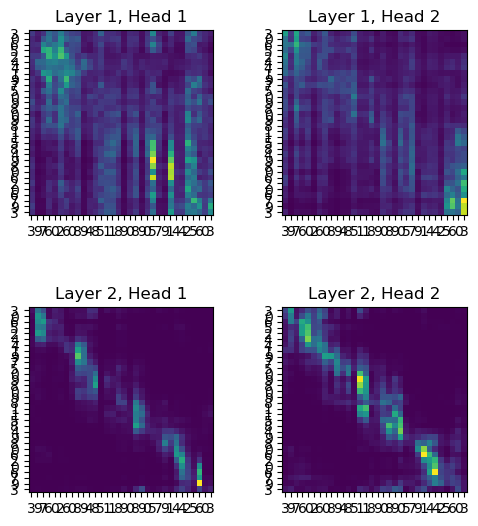

In [14]:
plot_attention_maps(seqs, attn_maps, idx=0)

### Model structure

In [15]:
reverse_model

TransformerPredictor(
  (transformer): TransformerEncoder(
    (embedding): Embedding(10, 32)
    (pe): PositionalEncoding()
    (enc_blocks): ModuleList(
      (0-1): 2 x EncoderBlock(
        (attn): MultiHeadAttention(
          (wq): Linear(in_features=32, out_features=16, bias=True)
          (wk): Linear(in_features=32, out_features=16, bias=True)
          (wv): Linear(in_features=32, out_features=16, bias=True)
          (linear): Linear(in_features=16, out_features=32, bias=True)
        )
        (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (mlp): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): Dropout(p=0.0, inplace=False)
          (2): ReLU()
          (3): Linear(in_features=128, out_features=32, bias=True)
        )
      )
    )
    (output_layer): Linear(in_features=32, out_features=10,

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(reverse_model):,} trainable parameters')

The model has 21,866 trainable parameters
